### Lesson functions

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline
from project_functions import *

### HOG Sub-sampling

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_colorspace(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

#             test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1)) 
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles is True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((top_left, bottom_right))
    return boxes

/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


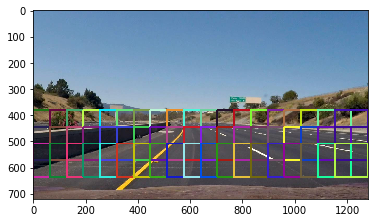

In [3]:

dist_pickle = pickle.load( open("data/svc_pickle_hsv.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

hog_channel = dist_pickle['hog_channel']
color_space = dist_pickle['color_space']

# img = mpimg.imread('test_image.jpg')
# img = mpimg.imread('test_images/bbox-example-image.jpg')
# img = mpimg.imread('test_images/test1.jpg')
img = mpimg.imread('test_images/project_video/0.jpg')


ystart = 380
ystop = 650
scale = 2
    
boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True)

    
out_img = draw_boxes(img, boxes, True)
plt.imshow(out_img)
np.mean(out_img)
plt.imsave('output_images/color_coded_search_boxes.png', out_img)

/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


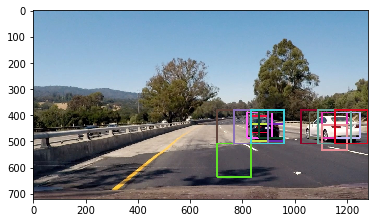

In [4]:

image = mpimg.imread('test_images/test4.jpg')

boxes_1 = find_cars(image, 370, 520, 1, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, False)
boxes_2 = find_cars(image, 390, 550, 1.5, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, False)
boxes_3 = find_cars(image, 380, 650, 2, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, False)
boxes_4 = find_cars(image, 410, 680, 2.5, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, False)
boxes_5 = find_cars(image, 400, 700, 3, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, False)
box_list = boxes_1 + boxes_2 + boxes_3 + boxes_4 + boxes_5

all_boxes = boxes_1 + boxes_2 + boxes_3
# np.concatenate((boxes_1, boxes_2, boxes_3))

out_img = draw_boxes(image, all_boxes)
plt.imshow(out_img)

plt.imsave('output_images/color_search_5.png', out_img)

# pickle.dump(all_boxes, open("data/bbox_pickle_video.p", "wb" ) )